# Assignment 3  
## Applied Machine Learning

Andrew Chan 
EBE869

In [98]:
import pandas as pd
import math
import numpy as np

# Locate and load the data file
df = pd.read_csv('master.csv')

# Sanity check
print(f'N rows={len(df)}, M columns={len(df.columns)}')
df.head()

N rows=27820, M columns=12


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [99]:
df.columns.values

array(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype=object)

# 1. [20 pts] Due to the severity of this real-world crisis, what information would be the most important one to "machine learn"? Can it be learned?

The most important target variable to machine learn is `suicides_no`. To attempt a machine learning solution we will turn this into a binary classification problem of `low suicide rate` versus `high suicide rate`. Framing the problem this way will allow us to train a classifier. 

# 2. [20 pts] Explain in detail how one should set up the problem? Would it be a regression or a classification problem? Any unsupervised approach to see some patterns exist or not?

# 3. [20 pts] What should be the dependent variable?

# 4. [20 pts] Rank the variables to find some strong correlations between the independent variables and the dependent variable you decided

# 5. [20 pts] Pre-process the dataset and list the major features you want to use. 
Note that not all features are crucial. For example, country-year variable is a derived feature and for a classifier it would not be necessary to include the year, the country and the country-year together. In fact, one must avoid adding a derived feature and the original at the same time.

List the independent features you want to use.

# 6. [20 pts bonus] Devise a classification problem and present a prototype model.
Note that we will continue to this problem in the following modules.

## Answer:

In [100]:
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import sklearn.datasets
import pandas as pd
iris = sklearn.datasets.load_iris()

In [101]:
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [102]:
X = iris.data

In [103]:
y = iris.target

In [104]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

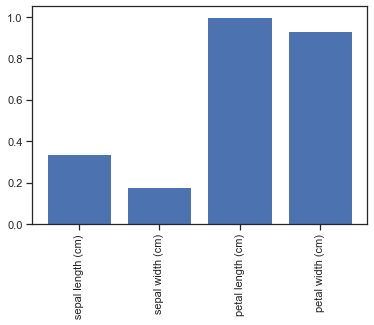

In [105]:
# Standard libraries we always include
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, f_classif


selector = SelectPercentile(f_classif, percentile=10)
# Fit the data
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

# Display
cols = list(iris.feature_names)
y_pos = np.arange(len(cols))
plt.bar(y_pos, scores)
plt.xticks(y_pos, cols, rotation=90)
plt.show()

In [106]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [107]:
X = X[:,(2,3)]

In [110]:
data = iris.data
n_samples = len(iris.data)
X_train, X_test, y_train, expected = train_test_split(X, iris.target, test_size=0.5, random_state=0)
classifier = GaussianNB()
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
print(f'Classification report for classifier {classifier}:\n{metrics.accuracy_score(expected, predicted)}\n')

Classification report for classifier GaussianNB():
0.9466666666666667



In [111]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(f'Classification report for classifier {clf}:\n{metrics.accuracy_score(expected, predicted)}\n')

Classification report for classifier SVC():
0.9466666666666667



# a

In [112]:
df = pd.read_csv('xor.csv')

In [113]:
df

,input 1,input 2,output
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [114]:
df.corr()

,input 1,input 2,output
input 1,1.0,0.0,0.0
input 2,0.0,1.0,0.0
output,0.0,0.0,1.0
